In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [2]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        for i in range(linear_layers - 1):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(linear)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data = self.convex[i*2].weight.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data = self.linear[i*2].weight.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        if not x.requires_grad:
            x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad#.detach()

In [3]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], compute_extra_reg=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]
        self.compute_extra_reg = compute_extra_reg

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y, grad_psi_omega):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * self.to_omega(Y), dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, Y, grad_psi_omega):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2]
        """
        # Forward: omega -> theta
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y)
        cycle_loss = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))

        return cycle_loss # THETA

    def compute_extra_R(self, X):
        """
        Compute extra regularization term
        R_X = (1/K) * [sum ||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(grad_psi_theta))

        # Compute squared difference
        diff = grad_psi_omega - self.to_omega(X)
        r_reg = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))
        return r_reg

    def compute_loss(self, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        # Step 2: Compute correlations
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y)).detach() # heuristic from Appendix C.1
        loss_corr = self.compute_correlations(X, Y, grad_psi_omega)

        # Step 3: Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(Y, grad_psi_omega)

        # Step 4: Total loss
        if self.compute_extra_reg:
            loss_R = self.compute_extra_R(X)
            loss_R_item = loss_R.item()
            loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle + loss_R
        else:
            loss_R = None
            loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle

        # Step 5: Gradient step
        loss_total.backward()

        return {
            'loss_corr': loss_corr.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item(),
            'loss_R': loss_R_item
        }

    def pretrain_loss(self, X):
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        loss_mse = F.mse_loss(grad_psi_theta, X)
        loss_mse.backward()

        return loss_mse

    def apply_pretrain_weights(self):
        self.psi_omega.load_state_dict(self.psi_theta.state_dict())

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        return self.psi_theta.gradient(X).detach()

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        return self.psi_omega.gradient(Y).detach()

In [4]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3, pre_lr=1e-3):
        self.loss_c = loss_c
        self.optimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()) +
           list(self.loss_c.psi_omega.parameters()),
           lr=lr
        )

        self.preoptimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()),
           lr=pre_lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': [], 'loss_R': []}
        self.history_pre = []

    def step(self, X, Y):
        self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(X, Y)
        self.optimizer.step()
        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()
            self.loss_c.psi_omega.update_weights()

        for x in losses.keys():
            if losses[x] is not None:
                self.history[x].append(losses[x])

        return losses

    def pretrain_step(self, X):
        self.preoptimizer.zero_grad()
        loss = self.loss_c.pretrain_loss(X)
        self.preoptimizer.step()
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()

        self.history_pre.append(loss)

        return loss

    def apply_pretrain(self):
        self.loss_c.apply_pretrain_weights()
        del self.preoptimizer

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

Using Colab cache for faster access to the 'summer2winter-yosemite' dataset.


In [6]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val

        self.trainA = "trainA"
        self.testA = "testA"
        self.trainB = "trainB"
        self.testB = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.imagesA = os.listdir(os.path.join(root, self.trainA))
            self.imagesB = os.listdir(os.path.join(root, self.trainB))
        else:
            self.imagesA = os.listdir(os.path.join(root, self.testA))
            self.imagesB = os.listdir(os.path.join(root, self.testB))

        self.pics = min(len(self.imagesA), len(self.imagesB))

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dirA, pic_dirB):
        img_pathA = os.path.join(self.root, pic_dirA, self.imagesA[idx])
        img_pathB = os.path.join(self.root, pic_dirB, self.imagesB[idx])

        # Load the image
        imgA = Image.open(img_pathA).resize((self.target_shape, self.target_shape))
        imgB = Image.open(img_pathB).resize((self.target_shape, self.target_shape))

        return torch.as_tensor(np.stack([
            np.asarray(imgA, dtype=np.float32), np.asarray(imgB, dtype=np.float32)
        ]) / 128.0 - 1.0).permute(0, 3, 1, 2), {}

    @staticmethod
    def take(t, A: bool):
        if A:
            return t[:, 0]
        else:
            return t[:, 1]

    @staticmethod
    def to_image(t):
        return (t.permute(0, 2, 3, 1) + 1.0) * 128.0

    def get_train(self, idx):
        return self.get(idx, self.trainA, self.trainB)

    def get_val(self, idx):
        return self.get(idx, self.testA, self.testB)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [7]:
batch_size = 16
dataset = S2WDataset(path, 128)

datasetVal = S2WDataset(path, 128, is_val=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

In [8]:
psi_theta = ConvICNN()
psi_omega = ConvICNN()
loss_c = W2GNLoss(psi_theta, psi_omega, lambda_cycle=100.0, compute_extra_reg=True)
trainer = W2GNTrainer(loss_c, lr=1e-5, pre_lr=1e-5 * 5)

In [34]:
# Pretrain
epochs = 5
for epoch in range(epochs):
    A_iter = iter(dataloader)
    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X = dataloader.dataset.take(next(A_iter)[0], A=True)
        loss = trainer.pretrain_step(X.to(trainer.loss_c.theta_device()))
        print(f"Epoch {epoch}: MSE={loss:.4f}")

Epoch 1/5:   2%|▏         | 1/61 [00:01<01:03,  1.05s/it]

Epoch 0: MSE=0.3190


Epoch 1/5:   3%|▎         | 2/61 [00:01<00:55,  1.05it/s]

Epoch 0: MSE=2.3713


Epoch 1/5:   5%|▍         | 3/61 [00:02<00:53,  1.09it/s]

Epoch 0: MSE=0.6568


Epoch 1/5:   7%|▋         | 4/61 [00:03<00:51,  1.11it/s]

Epoch 0: MSE=1.4362


Epoch 1/5:   8%|▊         | 5/61 [00:04<00:50,  1.11it/s]

Epoch 0: MSE=1.1298


Epoch 1/5:  10%|▉         | 6/61 [00:05<00:49,  1.12it/s]

Epoch 0: MSE=0.4489


Epoch 1/5:  11%|█▏        | 7/61 [00:06<00:48,  1.12it/s]

Epoch 0: MSE=0.3503


Epoch 1/5:  13%|█▎        | 8/61 [00:07<00:47,  1.11it/s]

Epoch 0: MSE=0.6094


Epoch 1/5:  15%|█▍        | 9/61 [00:08<00:46,  1.11it/s]

Epoch 0: MSE=0.7413


Epoch 1/5:  16%|█▋        | 10/61 [00:09<00:46,  1.10it/s]

Epoch 0: MSE=0.5649


Epoch 1/5:  18%|█▊        | 11/61 [00:10<00:45,  1.09it/s]

Epoch 0: MSE=0.3416


Epoch 1/5:  20%|█▉        | 12/61 [00:11<00:46,  1.06it/s]

Epoch 0: MSE=0.1918


Epoch 1/5:  21%|██▏       | 13/61 [00:12<00:47,  1.01it/s]

Epoch 0: MSE=0.1757


Epoch 1/5:  23%|██▎       | 14/61 [00:13<00:48,  1.03s/it]

Epoch 0: MSE=0.2611


Epoch 1/5:  25%|██▍       | 15/61 [00:14<00:48,  1.06s/it]

Epoch 0: MSE=0.3207


Epoch 1/5:  26%|██▌       | 16/61 [00:15<00:48,  1.07s/it]

Epoch 0: MSE=0.3045


Epoch 1/5:  28%|██▊       | 17/61 [00:16<00:47,  1.08s/it]

Epoch 0: MSE=0.2298


Epoch 1/5:  30%|██▉       | 18/61 [00:17<00:45,  1.07s/it]

Epoch 0: MSE=0.1661


Epoch 1/5:  31%|███       | 19/61 [00:18<00:43,  1.03s/it]

Epoch 0: MSE=0.1202


Epoch 1/5:  33%|███▎      | 20/61 [00:19<00:40,  1.01it/s]

Epoch 0: MSE=0.1318


Epoch 1/5:  34%|███▍      | 21/61 [00:20<00:38,  1.03it/s]

Epoch 0: MSE=0.1628


Epoch 1/5:  36%|███▌      | 22/61 [00:21<00:36,  1.06it/s]

Epoch 0: MSE=0.1724


Epoch 1/5:  38%|███▊      | 23/61 [00:22<00:35,  1.07it/s]

Epoch 0: MSE=0.1656


Epoch 1/5:  39%|███▉      | 24/61 [00:23<00:34,  1.08it/s]

Epoch 0: MSE=0.1594


Epoch 1/5:  41%|████      | 25/61 [00:23<00:32,  1.10it/s]

Epoch 0: MSE=0.1182


Epoch 1/5:  43%|████▎     | 26/61 [00:24<00:31,  1.10it/s]

Epoch 0: MSE=0.0996


Epoch 1/5:  44%|████▍     | 27/61 [00:25<00:30,  1.11it/s]

Epoch 0: MSE=0.0798


Epoch 1/5:  46%|████▌     | 28/61 [00:26<00:29,  1.12it/s]

Epoch 0: MSE=0.0863


Epoch 1/5:  48%|████▊     | 29/61 [00:27<00:28,  1.12it/s]

Epoch 0: MSE=0.0962


Epoch 1/5:  49%|████▉     | 30/61 [00:28<00:27,  1.12it/s]

Epoch 0: MSE=0.1039


Epoch 1/5:  51%|█████     | 31/61 [00:29<00:26,  1.12it/s]

Epoch 0: MSE=0.1063


Epoch 1/5:  52%|█████▏    | 32/61 [00:30<00:25,  1.13it/s]

Epoch 0: MSE=0.1098


Epoch 1/5:  54%|█████▍    | 33/61 [00:31<00:24,  1.13it/s]

Epoch 0: MSE=0.0969


Epoch 1/5:  56%|█████▌    | 34/61 [00:31<00:23,  1.13it/s]

Epoch 0: MSE=0.0994


Epoch 1/5:  57%|█████▋    | 35/61 [00:32<00:22,  1.14it/s]

Epoch 0: MSE=0.0783


Epoch 1/5:  59%|█████▉    | 36/61 [00:33<00:21,  1.14it/s]

Epoch 0: MSE=0.0815


Epoch 1/5:  61%|██████    | 37/61 [00:34<00:21,  1.14it/s]

Epoch 0: MSE=0.0748


Epoch 1/5:  62%|██████▏   | 38/61 [00:35<00:20,  1.15it/s]

Epoch 0: MSE=0.0809


Epoch 1/5:  64%|██████▍   | 39/61 [00:36<00:19,  1.15it/s]

Epoch 0: MSE=0.0924


Epoch 1/5:  66%|██████▌   | 40/61 [00:37<00:18,  1.15it/s]

Epoch 0: MSE=0.0828


Epoch 1/5:  67%|██████▋   | 41/61 [00:38<00:17,  1.15it/s]

Epoch 0: MSE=0.0783


Epoch 1/5:  69%|██████▉   | 42/61 [00:38<00:16,  1.15it/s]

Epoch 0: MSE=0.0782


Epoch 1/5:  70%|███████   | 43/61 [00:39<00:15,  1.15it/s]

Epoch 0: MSE=0.0628


Epoch 1/5:  72%|███████▏  | 44/61 [00:40<00:14,  1.15it/s]

Epoch 0: MSE=0.0700


Epoch 1/5:  74%|███████▍  | 45/61 [00:41<00:13,  1.15it/s]

Epoch 0: MSE=0.0674


Epoch 1/5:  75%|███████▌  | 46/61 [00:42<00:13,  1.15it/s]

Epoch 0: MSE=0.0675


Epoch 1/5:  77%|███████▋  | 47/61 [00:43<00:12,  1.15it/s]

Epoch 0: MSE=0.0751


Epoch 1/5:  79%|███████▊  | 48/61 [00:44<00:11,  1.16it/s]

Epoch 0: MSE=0.0747


Epoch 1/5:  80%|████████  | 49/61 [00:44<00:10,  1.16it/s]

Epoch 0: MSE=0.0748


Epoch 1/5:  82%|████████▏ | 50/61 [00:45<00:09,  1.16it/s]

Epoch 0: MSE=0.0613


Epoch 1/5:  84%|████████▎ | 51/61 [00:46<00:08,  1.16it/s]

Epoch 0: MSE=0.0614


Epoch 1/5:  85%|████████▌ | 52/61 [00:47<00:07,  1.16it/s]

Epoch 0: MSE=0.0538


Epoch 1/5:  87%|████████▋ | 53/61 [00:48<00:06,  1.17it/s]

Epoch 0: MSE=0.0597


Epoch 1/5:  89%|████████▊ | 54/61 [00:49<00:06,  1.17it/s]

Epoch 0: MSE=0.0722


Epoch 1/5:  90%|█████████ | 55/61 [00:50<00:05,  1.17it/s]

Epoch 0: MSE=0.0742


Epoch 1/5:  92%|█████████▏| 56/61 [00:50<00:04,  1.17it/s]

Epoch 0: MSE=0.0699


Epoch 1/5:  93%|█████████▎| 57/61 [00:51<00:03,  1.17it/s]

Epoch 0: MSE=0.0651


Epoch 1/5:  95%|█████████▌| 58/61 [00:52<00:02,  1.17it/s]

Epoch 0: MSE=0.0615


Epoch 1/5:  97%|█████████▋| 59/61 [00:53<00:01,  1.17it/s]

Epoch 0: MSE=0.0631


Epoch 0: MSE=0.0649
Epoch 0: MSE=0.0423


Epoch 2/5:   2%|▏         | 1/61 [00:00<00:56,  1.07it/s]

Epoch 1: MSE=0.0725


Epoch 2/5:   3%|▎         | 2/61 [00:01<00:52,  1.12it/s]

Epoch 1: MSE=0.0662


Epoch 2/5:   5%|▍         | 3/61 [00:02<00:50,  1.14it/s]

Epoch 1: MSE=0.0617


Epoch 2/5:   7%|▋         | 4/61 [00:03<00:49,  1.16it/s]

Epoch 1: MSE=0.0605


Epoch 2/5:   8%|▊         | 5/61 [00:04<00:48,  1.16it/s]

Epoch 1: MSE=0.0704


Epoch 2/5:  10%|▉         | 6/61 [00:05<00:47,  1.17it/s]

Epoch 1: MSE=0.0615


Epoch 2/5:  11%|█▏        | 7/61 [00:06<00:46,  1.17it/s]

Epoch 1: MSE=0.0674


Epoch 2/5:  13%|█▎        | 8/61 [00:06<00:45,  1.17it/s]

Epoch 1: MSE=0.0586


Epoch 2/5:  15%|█▍        | 9/61 [00:07<00:44,  1.17it/s]

Epoch 1: MSE=0.0603


Epoch 2/5:  16%|█▋        | 10/61 [00:08<00:43,  1.17it/s]

Epoch 1: MSE=0.0602


Epoch 2/5:  18%|█▊        | 11/61 [00:09<00:42,  1.17it/s]

Epoch 1: MSE=0.0546


Epoch 2/5:  20%|█▉        | 12/61 [00:10<00:41,  1.17it/s]

Epoch 1: MSE=0.0564


Epoch 2/5:  21%|██▏       | 13/61 [00:11<00:40,  1.18it/s]

Epoch 1: MSE=0.0582


Epoch 2/5:  23%|██▎       | 14/61 [00:12<00:40,  1.17it/s]

Epoch 1: MSE=0.0607


Epoch 2/5:  25%|██▍       | 15/61 [00:12<00:39,  1.17it/s]

Epoch 1: MSE=0.0621


Epoch 2/5:  26%|██▌       | 16/61 [00:13<00:38,  1.17it/s]

Epoch 1: MSE=0.0615


Epoch 2/5:  28%|██▊       | 17/61 [00:14<00:37,  1.17it/s]

Epoch 1: MSE=0.0647


Epoch 2/5:  30%|██▉       | 18/61 [00:15<00:36,  1.17it/s]

Epoch 1: MSE=0.0664


Epoch 2/5:  31%|███       | 19/61 [00:16<00:35,  1.17it/s]

Epoch 1: MSE=0.0577


Epoch 2/5:  33%|███▎      | 20/61 [00:17<00:34,  1.17it/s]

Epoch 1: MSE=0.0621


Epoch 2/5:  34%|███▍      | 21/61 [00:17<00:34,  1.17it/s]

Epoch 1: MSE=0.0615


Epoch 2/5:  36%|███▌      | 22/61 [00:18<00:33,  1.17it/s]

Epoch 1: MSE=0.0600


Epoch 2/5:  38%|███▊      | 23/61 [00:19<00:32,  1.17it/s]

Epoch 1: MSE=0.0624


Epoch 2/5:  39%|███▉      | 24/61 [00:20<00:31,  1.17it/s]

Epoch 1: MSE=0.0625


Epoch 2/5:  41%|████      | 25/61 [00:21<00:30,  1.17it/s]

Epoch 1: MSE=0.0485


Epoch 2/5:  43%|████▎     | 26/61 [00:22<00:29,  1.17it/s]

Epoch 1: MSE=0.0690


Epoch 2/5:  44%|████▍     | 27/61 [00:23<00:29,  1.17it/s]

Epoch 1: MSE=0.0507


Epoch 2/5:  46%|████▌     | 28/61 [00:23<00:28,  1.17it/s]

Epoch 1: MSE=0.0619


Epoch 2/5:  48%|████▊     | 29/61 [00:24<00:27,  1.16it/s]

Epoch 1: MSE=0.0579


Epoch 2/5:  49%|████▉     | 30/61 [00:25<00:26,  1.17it/s]

Epoch 1: MSE=0.0600


Epoch 2/5:  51%|█████     | 31/61 [00:26<00:25,  1.16it/s]

Epoch 1: MSE=0.0576


Epoch 2/5:  52%|█████▏    | 32/61 [00:27<00:24,  1.16it/s]

Epoch 1: MSE=0.0582


Epoch 2/5:  54%|█████▍    | 33/61 [00:28<00:24,  1.16it/s]

Epoch 1: MSE=0.0508


Epoch 2/5:  56%|█████▌    | 34/61 [00:29<00:23,  1.16it/s]

Epoch 1: MSE=0.0588


Epoch 2/5:  57%|█████▋    | 35/61 [00:29<00:22,  1.16it/s]

Epoch 1: MSE=0.0587


Epoch 2/5:  59%|█████▉    | 36/61 [00:30<00:21,  1.16it/s]

Epoch 1: MSE=0.0566


Epoch 2/5:  61%|██████    | 37/61 [00:31<00:20,  1.16it/s]

Epoch 1: MSE=0.0571


Epoch 2/5:  62%|██████▏   | 38/61 [00:32<00:19,  1.15it/s]

Epoch 1: MSE=0.0483


Epoch 2/5:  64%|██████▍   | 39/61 [00:33<00:19,  1.15it/s]

Epoch 1: MSE=0.0580


Epoch 2/5:  66%|██████▌   | 40/61 [00:34<00:18,  1.15it/s]

Epoch 1: MSE=0.0551


Epoch 2/5:  67%|██████▋   | 41/61 [00:35<00:17,  1.15it/s]

Epoch 1: MSE=0.0575


Epoch 2/5:  69%|██████▉   | 42/61 [00:36<00:16,  1.15it/s]

Epoch 1: MSE=0.0534


Epoch 2/5:  70%|███████   | 43/61 [00:36<00:15,  1.15it/s]

Epoch 1: MSE=0.0521


Epoch 2/5:  72%|███████▏  | 44/61 [00:37<00:14,  1.15it/s]

Epoch 1: MSE=0.0529


Epoch 2/5:  74%|███████▍  | 45/61 [00:38<00:13,  1.15it/s]

Epoch 1: MSE=0.0567


Epoch 2/5:  75%|███████▌  | 46/61 [00:39<00:13,  1.15it/s]

Epoch 1: MSE=0.0509


Epoch 2/5:  77%|███████▋  | 47/61 [00:40<00:12,  1.15it/s]

Epoch 1: MSE=0.0554


Epoch 2/5:  79%|███████▊  | 48/61 [00:41<00:11,  1.15it/s]

Epoch 1: MSE=0.0531


Epoch 2/5:  80%|████████  | 49/61 [00:42<00:10,  1.15it/s]

Epoch 1: MSE=0.0583


Epoch 2/5:  82%|████████▏ | 50/61 [00:43<00:09,  1.15it/s]

Epoch 1: MSE=0.0604


Epoch 2/5:  84%|████████▎ | 51/61 [00:43<00:08,  1.15it/s]

Epoch 1: MSE=0.0514


Epoch 2/5:  85%|████████▌ | 52/61 [00:44<00:07,  1.15it/s]

Epoch 1: MSE=0.0548


Epoch 2/5:  87%|████████▋ | 53/61 [00:45<00:06,  1.15it/s]

Epoch 1: MSE=0.0525


Epoch 2/5:  89%|████████▊ | 54/61 [00:46<00:06,  1.15it/s]

Epoch 1: MSE=0.0493


Epoch 2/5:  90%|█████████ | 55/61 [00:47<00:05,  1.15it/s]

Epoch 1: MSE=0.0546


Epoch 2/5:  92%|█████████▏| 56/61 [00:48<00:04,  1.15it/s]

Epoch 1: MSE=0.0606


Epoch 2/5:  93%|█████████▎| 57/61 [00:49<00:03,  1.15it/s]

Epoch 1: MSE=0.0570


Epoch 2/5:  95%|█████████▌| 58/61 [00:50<00:02,  1.15it/s]

Epoch 1: MSE=0.0543


Epoch 2/5:  97%|█████████▋| 59/61 [00:50<00:01,  1.15it/s]

Epoch 1: MSE=0.0584


Epoch 1: MSE=0.0486
Epoch 1: MSE=0.0362


Epoch 3/5:   2%|▏         | 1/61 [00:00<00:59,  1.00it/s]

Epoch 2: MSE=0.0594


Epoch 3/5:   3%|▎         | 2/61 [00:01<00:54,  1.08it/s]

Epoch 2: MSE=0.0526


Epoch 3/5:   5%|▍         | 3/61 [00:02<00:52,  1.11it/s]

Epoch 2: MSE=0.0520


Epoch 3/5:   7%|▋         | 4/61 [00:03<00:50,  1.13it/s]

Epoch 2: MSE=0.0456


Epoch 3/5:   8%|▊         | 5/61 [00:04<00:49,  1.13it/s]

Epoch 2: MSE=0.0529


Epoch 3/5:  10%|▉         | 6/61 [00:05<00:48,  1.14it/s]

Epoch 2: MSE=0.0544


Epoch 3/5:  11%|█▏        | 7/61 [00:06<00:47,  1.14it/s]

Epoch 2: MSE=0.0504


Epoch 3/5:  13%|█▎        | 8/61 [00:07<00:46,  1.14it/s]

Epoch 2: MSE=0.0540


Epoch 3/5:  15%|█▍        | 9/61 [00:07<00:45,  1.14it/s]

Epoch 2: MSE=0.0553


Epoch 3/5:  16%|█▋        | 10/61 [00:08<00:44,  1.15it/s]

Epoch 2: MSE=0.0580


Epoch 3/5:  18%|█▊        | 11/61 [00:09<00:43,  1.15it/s]

Epoch 2: MSE=0.0475


Epoch 3/5:  20%|█▉        | 12/61 [00:10<00:42,  1.15it/s]

Epoch 2: MSE=0.0560


Epoch 3/5:  21%|██▏       | 13/61 [00:11<00:41,  1.15it/s]

Epoch 2: MSE=0.0468


Epoch 3/5:  23%|██▎       | 14/61 [00:12<00:40,  1.15it/s]

Epoch 2: MSE=0.0480


Epoch 3/5:  25%|██▍       | 15/61 [00:13<00:40,  1.15it/s]

Epoch 2: MSE=0.0401


Epoch 3/5:  26%|██▌       | 16/61 [00:14<00:39,  1.15it/s]

Epoch 2: MSE=0.0451


Epoch 3/5:  28%|██▊       | 17/61 [00:14<00:38,  1.15it/s]

Epoch 2: MSE=0.0558


Epoch 3/5:  30%|██▉       | 18/61 [00:15<00:37,  1.15it/s]

Epoch 2: MSE=0.0593


Epoch 3/5:  31%|███       | 19/61 [00:16<00:36,  1.15it/s]

Epoch 2: MSE=0.0491


Epoch 3/5:  33%|███▎      | 20/61 [00:17<00:35,  1.15it/s]

Epoch 2: MSE=0.0559


Epoch 3/5:  34%|███▍      | 21/61 [00:18<00:34,  1.15it/s]

Epoch 2: MSE=0.0507


Epoch 3/5:  36%|███▌      | 22/61 [00:19<00:33,  1.15it/s]

Epoch 2: MSE=0.0468


Epoch 3/5:  38%|███▊      | 23/61 [00:20<00:33,  1.15it/s]

Epoch 2: MSE=0.0487


Epoch 3/5:  39%|███▉      | 24/61 [00:21<00:32,  1.15it/s]

Epoch 2: MSE=0.0493


Epoch 3/5:  41%|████      | 25/61 [00:21<00:31,  1.15it/s]

Epoch 2: MSE=0.0558


Epoch 3/5:  43%|████▎     | 26/61 [00:22<00:30,  1.15it/s]

Epoch 2: MSE=0.0517


Epoch 3/5:  44%|████▍     | 27/61 [00:23<00:29,  1.15it/s]

Epoch 2: MSE=0.0447


Epoch 3/5:  46%|████▌     | 28/61 [00:24<00:28,  1.15it/s]

Epoch 2: MSE=0.0445


Epoch 3/5:  48%|████▊     | 29/61 [00:25<00:27,  1.15it/s]

Epoch 2: MSE=0.0468


Epoch 3/5:  49%|████▉     | 30/61 [00:26<00:26,  1.15it/s]

Epoch 2: MSE=0.0534


Epoch 3/5:  51%|█████     | 31/61 [00:27<00:26,  1.15it/s]

Epoch 2: MSE=0.0488


Epoch 3/5:  52%|█████▏    | 32/61 [00:27<00:25,  1.15it/s]

Epoch 2: MSE=0.0462


Epoch 3/5:  54%|█████▍    | 33/61 [00:28<00:24,  1.15it/s]

Epoch 2: MSE=0.0433


Epoch 3/5:  56%|█████▌    | 34/61 [00:29<00:23,  1.15it/s]

Epoch 2: MSE=0.0522


Epoch 3/5:  57%|█████▋    | 35/61 [00:30<00:22,  1.15it/s]

Epoch 2: MSE=0.0521


Epoch 3/5:  59%|█████▉    | 36/61 [00:31<00:21,  1.15it/s]

Epoch 2: MSE=0.0515


Epoch 3/5:  61%|██████    | 37/61 [00:32<00:20,  1.16it/s]

Epoch 2: MSE=0.0543


Epoch 3/5:  62%|██████▏   | 38/61 [00:33<00:19,  1.16it/s]

Epoch 2: MSE=0.0523


Epoch 3/5:  64%|██████▍   | 39/61 [00:34<00:19,  1.15it/s]

Epoch 2: MSE=0.0528


Epoch 3/5:  66%|██████▌   | 40/61 [00:34<00:18,  1.16it/s]

Epoch 2: MSE=0.0543


Epoch 3/5:  67%|██████▋   | 41/61 [00:35<00:17,  1.16it/s]

Epoch 2: MSE=0.0412


Epoch 3/5:  69%|██████▉   | 42/61 [00:36<00:16,  1.16it/s]

Epoch 2: MSE=0.0471


Epoch 3/5:  70%|███████   | 43/61 [00:37<00:15,  1.16it/s]

Epoch 2: MSE=0.0479


Epoch 3/5:  72%|███████▏  | 44/61 [00:38<00:14,  1.16it/s]

Epoch 2: MSE=0.0451


Epoch 3/5:  74%|███████▍  | 45/61 [00:39<00:13,  1.16it/s]

Epoch 2: MSE=0.0507


Epoch 3/5:  75%|███████▌  | 46/61 [00:40<00:12,  1.16it/s]

Epoch 2: MSE=0.0480


Epoch 3/5:  77%|███████▋  | 47/61 [00:40<00:12,  1.16it/s]

Epoch 2: MSE=0.0484


Epoch 3/5:  79%|███████▊  | 48/61 [00:41<00:11,  1.16it/s]

Epoch 2: MSE=0.0443


Epoch 3/5:  80%|████████  | 49/61 [00:42<00:10,  1.16it/s]

Epoch 2: MSE=0.0498


Epoch 3/5:  82%|████████▏ | 50/61 [00:43<00:09,  1.16it/s]

Epoch 2: MSE=0.0544


Epoch 3/5:  84%|████████▎ | 51/61 [00:44<00:08,  1.16it/s]

Epoch 2: MSE=0.0618


Epoch 3/5:  85%|████████▌ | 52/61 [00:45<00:07,  1.16it/s]

Epoch 2: MSE=0.0395


Epoch 3/5:  87%|████████▋ | 53/61 [00:46<00:06,  1.16it/s]

Epoch 2: MSE=0.0402


Epoch 3/5:  89%|████████▊ | 54/61 [00:46<00:06,  1.16it/s]

Epoch 2: MSE=0.0495


Epoch 3/5:  90%|█████████ | 55/61 [00:47<00:05,  1.16it/s]

Epoch 2: MSE=0.0467


Epoch 3/5:  92%|█████████▏| 56/61 [00:48<00:04,  1.16it/s]

Epoch 2: MSE=0.0467


Epoch 3/5:  93%|█████████▎| 57/61 [00:49<00:03,  1.16it/s]

Epoch 2: MSE=0.0465


Epoch 3/5:  95%|█████████▌| 58/61 [00:50<00:02,  1.15it/s]

Epoch 2: MSE=0.0433


Epoch 3/5:  97%|█████████▋| 59/61 [00:51<00:01,  1.16it/s]

Epoch 2: MSE=0.0469


Epoch 2: MSE=0.0433
Epoch 2: MSE=0.0625


Epoch 4/5:   2%|▏         | 1/61 [00:00<00:57,  1.05it/s]

Epoch 3: MSE=0.0464


Epoch 4/5:   3%|▎         | 2/61 [00:01<00:53,  1.10it/s]

Epoch 3: MSE=0.0346


Epoch 4/5:   5%|▍         | 3/61 [00:02<00:51,  1.13it/s]

Epoch 3: MSE=0.0495


Epoch 4/5:   7%|▋         | 4/61 [00:03<00:49,  1.14it/s]

Epoch 3: MSE=0.0470


Epoch 4/5:   8%|▊         | 5/61 [00:04<00:48,  1.15it/s]

Epoch 3: MSE=0.0455


Epoch 4/5:  10%|▉         | 6/61 [00:05<00:47,  1.15it/s]

Epoch 3: MSE=0.0480


Epoch 4/5:  11%|█▏        | 7/61 [00:06<00:46,  1.15it/s]

Epoch 3: MSE=0.0481


Epoch 4/5:  13%|█▎        | 8/61 [00:07<00:45,  1.15it/s]

Epoch 3: MSE=0.0545


Epoch 4/5:  15%|█▍        | 9/61 [00:07<00:45,  1.15it/s]

Epoch 3: MSE=0.0464


Epoch 4/5:  16%|█▋        | 10/61 [00:08<00:44,  1.15it/s]

Epoch 3: MSE=0.0484


Epoch 4/5:  18%|█▊        | 11/61 [00:09<00:43,  1.15it/s]

Epoch 3: MSE=0.0465


Epoch 4/5:  20%|█▉        | 12/61 [00:10<00:42,  1.15it/s]

Epoch 3: MSE=0.0447


Epoch 4/5:  21%|██▏       | 13/61 [00:11<00:41,  1.15it/s]

Epoch 3: MSE=0.0437


Epoch 4/5:  23%|██▎       | 14/61 [00:12<00:40,  1.16it/s]

Epoch 3: MSE=0.0470


Epoch 4/5:  25%|██▍       | 15/61 [00:13<00:39,  1.15it/s]

Epoch 3: MSE=0.0428


Epoch 4/5:  26%|██▌       | 16/61 [00:13<00:39,  1.15it/s]

Epoch 3: MSE=0.0475


Epoch 4/5:  28%|██▊       | 17/61 [00:14<00:38,  1.15it/s]

Epoch 3: MSE=0.0411


Epoch 4/5:  30%|██▉       | 18/61 [00:15<00:37,  1.16it/s]

Epoch 3: MSE=0.0489


Epoch 4/5:  31%|███       | 19/61 [00:16<00:36,  1.16it/s]

Epoch 3: MSE=0.0492


Epoch 4/5:  33%|███▎      | 20/61 [00:17<00:35,  1.15it/s]

Epoch 3: MSE=0.0609


Epoch 4/5:  34%|███▍      | 21/61 [00:18<00:34,  1.15it/s]

Epoch 3: MSE=0.0503


Epoch 4/5:  36%|███▌      | 22/61 [00:19<00:33,  1.16it/s]

Epoch 3: MSE=0.0417


Epoch 4/5:  38%|███▊      | 23/61 [00:20<00:32,  1.16it/s]

Epoch 3: MSE=0.0423


Epoch 4/5:  39%|███▉      | 24/61 [00:20<00:32,  1.15it/s]

Epoch 3: MSE=0.0409


Epoch 4/5:  41%|████      | 25/61 [00:21<00:32,  1.12it/s]

Epoch 3: MSE=0.0403


Epoch 4/5:  43%|████▎     | 26/61 [00:22<00:31,  1.10it/s]

Epoch 3: MSE=0.0434


Epoch 4/5:  44%|████▍     | 27/61 [00:23<00:31,  1.10it/s]

Epoch 3: MSE=0.0392


Epoch 4/5:  46%|████▌     | 28/61 [00:24<00:30,  1.09it/s]

Epoch 3: MSE=0.0415


Epoch 4/5:  48%|████▊     | 29/61 [00:25<00:29,  1.09it/s]

Epoch 3: MSE=0.0477


Epoch 4/5:  49%|████▉     | 30/61 [00:26<00:28,  1.08it/s]

Epoch 3: MSE=0.0454


Epoch 4/5:  51%|█████     | 31/61 [00:27<00:27,  1.08it/s]

Epoch 3: MSE=0.0422


Epoch 4/5:  52%|█████▏    | 32/61 [00:28<00:26,  1.08it/s]

Epoch 3: MSE=0.0486


Epoch 4/5:  54%|█████▍    | 33/61 [00:29<00:25,  1.08it/s]

Epoch 3: MSE=0.0378


Epoch 4/5:  56%|█████▌    | 34/61 [00:30<00:24,  1.08it/s]

Epoch 3: MSE=0.0443


Epoch 4/5:  57%|█████▋    | 35/61 [00:31<00:24,  1.08it/s]

Epoch 3: MSE=0.0528


Epoch 4/5:  59%|█████▉    | 36/61 [00:32<00:23,  1.08it/s]

Epoch 3: MSE=0.0463


Epoch 4/5:  61%|██████    | 37/61 [00:33<00:22,  1.07it/s]

Epoch 3: MSE=0.0471


Epoch 4/5:  62%|██████▏   | 38/61 [00:33<00:21,  1.06it/s]

Epoch 3: MSE=0.0383


Epoch 4/5:  64%|██████▍   | 39/61 [00:34<00:20,  1.05it/s]

Epoch 3: MSE=0.0411


Epoch 4/5:  66%|██████▌   | 40/61 [00:35<00:20,  1.05it/s]

Epoch 3: MSE=0.0433


Epoch 4/5:  67%|██████▋   | 41/61 [00:36<00:19,  1.05it/s]

Epoch 3: MSE=0.0452


Epoch 4/5:  69%|██████▉   | 42/61 [00:37<00:18,  1.04it/s]

Epoch 3: MSE=0.0428


Epoch 4/5:  70%|███████   | 43/61 [00:38<00:17,  1.04it/s]

Epoch 3: MSE=0.0446


Epoch 4/5:  72%|███████▏  | 44/61 [00:39<00:16,  1.04it/s]

Epoch 3: MSE=0.0423


Epoch 4/5:  74%|███████▍  | 45/61 [00:40<00:15,  1.04it/s]

Epoch 3: MSE=0.0422


Epoch 4/5:  75%|███████▌  | 46/61 [00:41<00:14,  1.04it/s]

Epoch 3: MSE=0.0482


Epoch 4/5:  77%|███████▋  | 47/61 [00:42<00:13,  1.04it/s]

Epoch 3: MSE=0.0357


Epoch 4/5:  79%|███████▊  | 48/61 [00:43<00:12,  1.04it/s]

Epoch 3: MSE=0.0408


Epoch 4/5:  80%|████████  | 49/61 [00:44<00:11,  1.04it/s]

Epoch 3: MSE=0.0398


Epoch 4/5:  82%|████████▏ | 50/61 [00:45<00:10,  1.04it/s]

Epoch 3: MSE=0.0415


Epoch 4/5:  84%|████████▎ | 51/61 [00:46<00:09,  1.04it/s]

Epoch 3: MSE=0.0316


Epoch 4/5:  85%|████████▌ | 52/61 [00:47<00:08,  1.04it/s]

Epoch 3: MSE=0.0379


Epoch 4/5:  87%|████████▋ | 53/61 [00:48<00:07,  1.04it/s]

Epoch 3: MSE=0.0432


Epoch 4/5:  89%|████████▊ | 54/61 [00:49<00:06,  1.04it/s]

Epoch 3: MSE=0.0417


Epoch 4/5:  90%|█████████ | 55/61 [00:50<00:05,  1.04it/s]

Epoch 3: MSE=0.0468


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 78.12 MiB is free. Process 124819 has 14.66 GiB memory in use. Of the allocated memory 13.91 GiB is allocated by PyTorch, and 628.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
trainer.apply_pretrain()

In [35]:
torch.save(trainer.loss_c.psi_theta.state_dict(), "./psi_pre2.pt")

In [9]:
trainer.loss_c.psi_theta.load_state_dict(torch.load("./psi_pre2.pt"))

<All keys matched successfully>

In [12]:
# Main training loop
epochs = 30
for epoch in range(epochs):
    d_iter = iter(dataloader)

    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        imgs = next(d_iter)[0]
        X = dataloader.dataset.take(imgs, A=True)
        Y = dataloader.dataset.take(imgs, A=False)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        loss_R = f"{losses['loss_R']:.4f}" if losses.get('loss_R') is not None else '?'
        print(f"\nEpoch {epoch}: " +
            f"Corr={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Reg={loss_R}, " +
            f"Total={losses['loss_total']:.4f}")

    Val_iter = iter(dataVal)
    X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
    Y_generated = trainer.generate(X_test).detach().cpu()

    cols = 8

    # Visualize
    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
    fig.suptitle('Place at summer / place at winter:')

    for i in range(cols):
        X_img = np.asarray(dataVal.dataset.to_image(X_test.cpu())[i], dtype=np.uint8)
        _ = axes[0][i].imshow(X_img)

        Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
        _ = axes[1][i].imshow(Y_img)

    #plt.tight_layout()
    fig.show()

Epoch 1/30:   2%|▏         | 1/61 [00:03<03:35,  3.59s/it]


Epoch 0: Corr=12788.6367, Cycle=5874.2520, Reg=5580.8848, Total=312082.0938


Epoch 1/30:   3%|▎         | 2/61 [00:07<03:26,  3.49s/it]


Epoch 0: Corr=-25923.2305, Cycle=99109.3516, Reg=67526.8125, Total=4997071.5000


Epoch 1/30:   5%|▍         | 3/61 [00:10<03:28,  3.60s/it]


Epoch 0: Corr=1399.8738, Cycle=17841.9062, Reg=18029.9258, Total=911525.1250


Epoch 1/30:   7%|▋         | 4/61 [00:15<03:50,  4.04s/it]


Epoch 0: Corr=855.1140, Cycle=14349.2598, Reg=13037.6504, Total=731355.7500


Epoch 1/30:   8%|▊         | 5/61 [00:18<03:33,  3.81s/it]


Epoch 0: Corr=69.6887, Cycle=14352.0752, Reg=19214.5586, Total=736888.0000


Epoch 1/30:  10%|▉         | 6/61 [00:22<03:21,  3.66s/it]


Epoch 0: Corr=0.0247, Cycle=15819.1611, Reg=17728.5020, Total=808686.5625


Epoch 1/30:  11%|█▏        | 7/61 [00:25<03:12,  3.57s/it]


Epoch 0: Corr=8.3178, Cycle=14526.9619, Reg=16660.6875, Total=743017.1250


Epoch 1/30:  13%|█▎        | 8/61 [00:28<03:04,  3.48s/it]


Epoch 0: Corr=6.2471, Cycle=16574.8223, Reg=16496.9531, Total=845244.3125


Epoch 1/30:  15%|█▍        | 9/61 [00:32<02:58,  3.42s/it]


Epoch 0: Corr=178.9138, Cycle=15723.2168, Reg=20535.7773, Total=806875.5000


Epoch 1/30:  16%|█▋        | 10/61 [00:35<02:52,  3.38s/it]


Epoch 0: Corr=2.1101, Cycle=15337.5566, Reg=15290.6006, Total=782170.5625


Epoch 1/30:  18%|█▊        | 11/61 [00:38<02:46,  3.33s/it]


Epoch 0: Corr=0.0222, Cycle=15058.7656, Reg=14272.4297, Total=767210.6875


Epoch 1/30:  20%|█▉        | 12/61 [00:41<02:41,  3.31s/it]


Epoch 0: Corr=0.5499, Cycle=15819.4844, Reg=16284.3340, Total=807259.1250


Epoch 1/30:  21%|██▏       | 13/61 [00:45<02:37,  3.28s/it]


Epoch 0: Corr=178.2569, Cycle=17270.2266, Reg=14465.0479, Total=878154.6250


Epoch 1/30:  23%|██▎       | 14/61 [00:48<02:33,  3.26s/it]


Epoch 0: Corr=20.2341, Cycle=15290.0068, Reg=15295.3418, Total=779815.8750


Epoch 1/30:  25%|██▍       | 15/61 [00:51<02:29,  3.25s/it]


Epoch 0: Corr=155.4101, Cycle=13760.9512, Reg=15871.7715, Total=704074.7500


Epoch 1/30:  26%|██▌       | 16/61 [00:54<02:25,  3.23s/it]


Epoch 0: Corr=94.6103, Cycle=15660.0977, Reg=15866.7207, Total=798966.2500


Epoch 1/30:  28%|██▊       | 17/61 [00:58<02:22,  3.23s/it]


Epoch 0: Corr=0.0229, Cycle=15259.0342, Reg=15351.4434, Total=778303.1250


Epoch 1/30:  30%|██▉       | 18/61 [01:01<02:18,  3.21s/it]


Epoch 0: Corr=0.0227, Cycle=15559.7305, Reg=14219.6465, Total=792206.1250


Epoch 1/30:  31%|███       | 19/61 [01:04<02:14,  3.20s/it]


Epoch 0: Corr=20.3990, Cycle=15557.5664, Reg=17647.9199, Total=795546.6250


Epoch 1/30:  33%|███▎      | 20/61 [01:07<02:11,  3.20s/it]


Epoch 0: Corr=7.0128, Cycle=14387.4844, Reg=13230.5869, Total=732611.8125


Epoch 1/30:  34%|███▍      | 21/61 [01:10<02:08,  3.20s/it]


Epoch 0: Corr=0.0215, Cycle=13157.5898, Reg=16650.2402, Total=674529.7500


Epoch 1/30:  36%|███▌      | 22/61 [01:13<02:04,  3.21s/it]


Epoch 0: Corr=0.0240, Cycle=16150.8477, Reg=15663.5742, Total=823205.9375


Epoch 1/30:  38%|███▊      | 23/61 [01:17<02:02,  3.21s/it]


Epoch 0: Corr=14.7454, Cycle=15062.5527, Reg=13402.9443, Total=766545.3125


Epoch 1/30:  39%|███▉      | 24/61 [01:20<01:58,  3.21s/it]


Epoch 0: Corr=24.0792, Cycle=16471.9023, Reg=15401.0352, Total=839020.2500


Epoch 1/30:  41%|████      | 25/61 [01:23<01:55,  3.22s/it]


Epoch 0: Corr=19.5898, Cycle=14577.2832, Reg=15170.9971, Total=744054.7500


Epoch 1/30:  43%|████▎     | 26/61 [01:26<01:52,  3.23s/it]


Epoch 0: Corr=0.0226, Cycle=15367.4512, Reg=14338.0566, Total=782710.6250


Epoch 1/30:  44%|████▍     | 27/61 [01:30<01:49,  3.23s/it]


Epoch 0: Corr=0.0222, Cycle=14261.6699, Reg=15385.9346, Total=728469.4375


Epoch 1/30:  46%|████▌     | 28/61 [01:33<01:46,  3.24s/it]


Epoch 0: Corr=0.0243, Cycle=16502.3828, Reg=13678.6719, Total=838797.8125


Epoch 1/30:  48%|████▊     | 29/61 [01:36<01:44,  3.25s/it]


Epoch 0: Corr=0.0213, Cycle=14044.8037, Reg=14410.0381, Total=716650.2500


Epoch 1/30:  49%|████▉     | 30/61 [01:39<01:41,  3.26s/it]


Epoch 0: Corr=0.0213, Cycle=13376.8125, Reg=15868.1680, Total=684708.8125


Epoch 1/30:  51%|█████     | 31/61 [01:43<01:38,  3.28s/it]


Epoch 0: Corr=0.0232, Cycle=15618.3838, Reg=15114.9229, Total=796034.1250


Epoch 1/30:  52%|█████▏    | 32/61 [01:46<01:35,  3.28s/it]


Epoch 0: Corr=342.1041, Cycle=14218.7012, Reg=17613.4785, Total=728890.6875


Epoch 1/30:  54%|█████▍    | 33/61 [01:49<01:31,  3.28s/it]


Epoch 0: Corr=0.0216, Cycle=14474.2471, Reg=13804.0312, Total=737516.3750


Epoch 1/30:  56%|█████▌    | 34/61 [01:53<01:28,  3.28s/it]


Epoch 0: Corr=0.0203, Cycle=13584.6113, Reg=13136.6152, Total=692367.1875


Epoch 1/30:  57%|█████▋    | 35/61 [01:56<01:25,  3.28s/it]


Epoch 0: Corr=0.0212, Cycle=14184.9941, Reg=13994.3037, Total=723244.0000


Epoch 1/30:  59%|█████▉    | 36/61 [01:59<01:22,  3.28s/it]


Epoch 0: Corr=0.0253, Cycle=15313.7168, Reg=17096.8086, Total=782782.6250


Epoch 1/30:  61%|██████    | 37/61 [02:03<01:18,  3.28s/it]


Epoch 0: Corr=0.1148, Cycle=15091.8926, Reg=12555.7812, Total=767150.5000


Epoch 1/30:  62%|██████▏   | 38/61 [02:06<01:15,  3.28s/it]


Epoch 0: Corr=0.0248, Cycle=16312.6133, Reg=16903.4023, Total=832534.0625


Epoch 1/30:  64%|██████▍   | 39/61 [02:09<01:11,  3.27s/it]


Epoch 0: Corr=0.0229, Cycle=14168.8262, Reg=17478.8691, Total=725920.1875


Epoch 1/30:  66%|██████▌   | 40/61 [02:12<01:08,  3.26s/it]


Epoch 0: Corr=0.0233, Cycle=14765.3525, Reg=17093.8730, Total=755361.5000


Epoch 1/30:  67%|██████▋   | 41/61 [02:16<01:05,  3.26s/it]


Epoch 0: Corr=1190.8916, Cycle=17314.5508, Reg=14867.2812, Total=881785.7500


Epoch 1/30:  69%|██████▉   | 42/61 [02:19<01:01,  3.25s/it]


Epoch 0: Corr=0.0235, Cycle=16400.2812, Reg=14199.4082, Total=834213.5000


Epoch 1/30:  70%|███████   | 43/61 [02:22<00:58,  3.25s/it]


Epoch 0: Corr=18.9001, Cycle=16594.3672, Reg=13589.3340, Total=843326.5625


Epoch 1/30:  72%|███████▏  | 44/61 [02:25<00:55,  3.24s/it]


Epoch 0: Corr=36.4029, Cycle=16945.7109, Reg=12411.3320, Total=859733.2500


Epoch 1/30:  74%|███████▍  | 45/61 [02:28<00:51,  3.23s/it]


Epoch 0: Corr=0.0219, Cycle=14050.4697, Reg=15736.3223, Total=718259.8125


Epoch 1/30:  75%|███████▌  | 46/61 [02:32<00:48,  3.24s/it]


Epoch 0: Corr=0.0240, Cycle=15554.5850, Reg=16671.6855, Total=794400.9375


Epoch 1/30:  77%|███████▋  | 47/61 [02:35<00:45,  3.23s/it]


Epoch 0: Corr=2.9633, Cycle=15155.2246, Reg=15263.4717, Total=773027.6875


Epoch 1/30:  79%|███████▊  | 48/61 [02:38<00:42,  3.23s/it]


Epoch 0: Corr=0.0231, Cycle=15747.7266, Reg=14459.7266, Total=801846.0625


Epoch 1/30:  80%|████████  | 49/61 [02:41<00:38,  3.24s/it]


Epoch 0: Corr=14.6746, Cycle=14632.0547, Reg=16401.7246, Total=748019.1875


Epoch 1/30:  82%|████████▏ | 50/61 [02:45<00:35,  3.24s/it]


Epoch 0: Corr=0.0238, Cycle=14939.2969, Reg=17652.9141, Total=764617.8125


Epoch 1/30:  84%|████████▎ | 51/61 [02:48<00:32,  3.24s/it]


Epoch 0: Corr=0.0229, Cycle=14146.4434, Reg=17491.0547, Total=724813.2500


KeyboardInterrupt: 

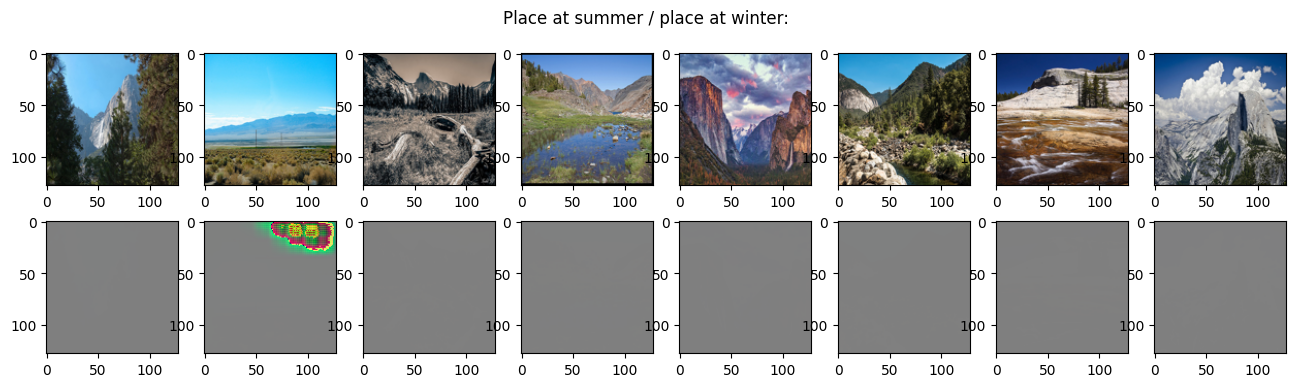

In [13]:
Val_iter = iter(dataVal)
X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
Y_generated = trainer.generate(X_test).detach().cpu()

cols = 8

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
fig.suptitle('Place at summer / place at winter:')

for i in range(cols):
    X_img = np.asarray(dataVal.dataset.to_image(X_test.cpu())[i], dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()